Sample y_train values: [1 0 1 1 0 0 1 0 0 0]


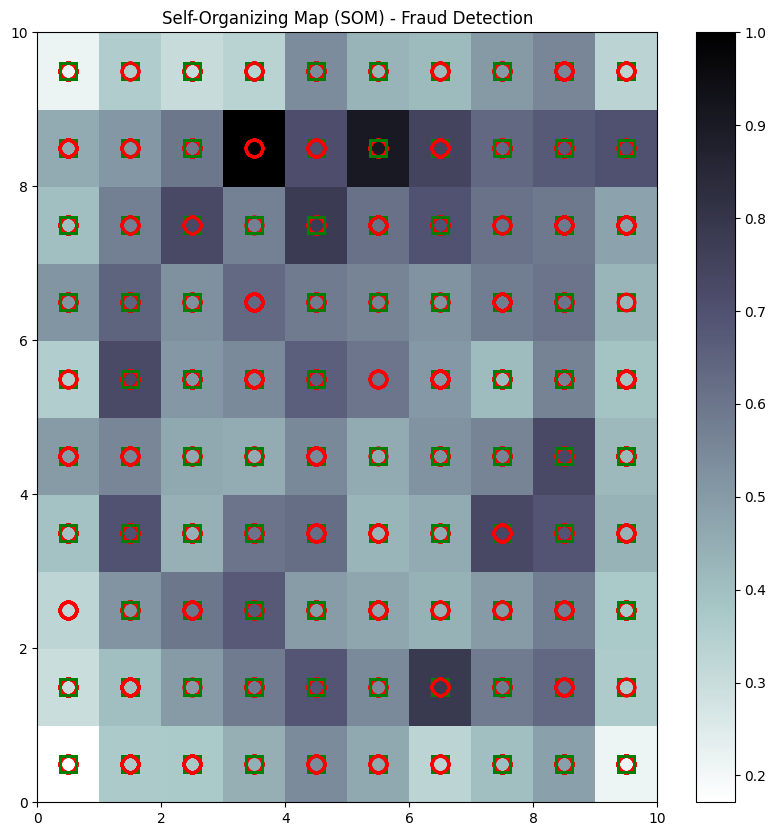

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom

# Assume X_train and y_train are defined
# Ensure y_train is a numpy array
y_train = np.array(y_train)

# Initialize and train the SOM
som_size = 10  # Define the size of the SOM grid
som = MiniSom(som_size, som_size, X_train.shape[1], sigma=0.5, learning_rate=0.5, random_seed=42)
som.random_weights_init(X_train)
som.train_random(X_train, 100)

# Visualize the SOM
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # Plot the distance map (U-Matrix)
plt.colorbar()

markers = ['o', 's']
colors = ['r', 'g']

# Print some values from y_train to debug
print("Sample y_train values:", y_train[:10])

for i, x in enumerate(X_train):
    w = som.winner(x)
    marker = markers[y_train[i]] if y_train[i] in [0, 1] else 'o'  # Default to 'o' if out of bounds
    color = colors[y_train[i]] if y_train[i] in [0, 1] else 'b'   # Default to 'b' if out of bounds
    plt.plot(w[0] + 0.5, w[1] + 0.5, marker, markerfacecolor='None',
             markeredgecolor=color, markersize=12, markeredgewidth=2)

plt.title('Self-Organizing Map (SOM) - Fraud Detection')
plt.show()


Confusion Matrix (Random Forest):
[[1355   70]
 [  47 1380]]
Classification Report (Random Forest):
              precision    recall  f1-score   support

   Non-Fraud       0.97      0.95      0.96      1425
       Fraud       0.95      0.97      0.96      1427

    accuracy                           0.96      2852
   macro avg       0.96      0.96      0.96      2852
weighted avg       0.96      0.96      0.96      2852



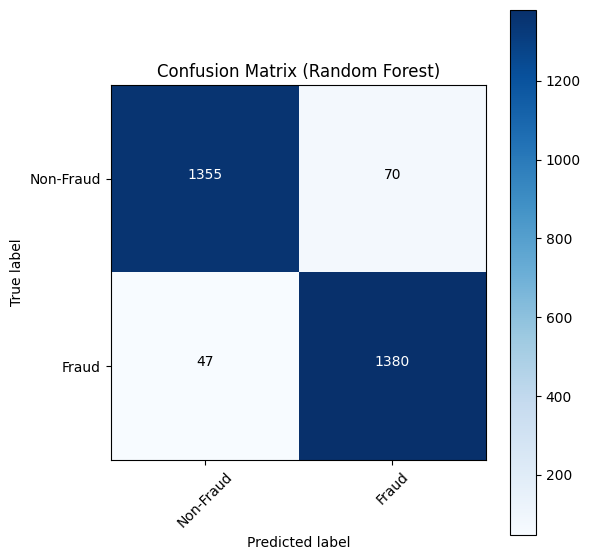

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Train the classifier
rf_clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred_rf = rf_clf.predict(X_test)

# Compute the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(cm_rf)

# Compute classification report
report_rf = classification_report(y_test, y_pred_rf, target_names=['Non-Fraud', 'Fraud'])
print("Classification Report (Random Forest):")
print(report_rf)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(cm_rf, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-Fraud', 'Fraud'], rotation=45)
plt.yticks(tick_marks, ['Non-Fraud', 'Fraud'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add values in confusion matrix
thresh = cm_rf.max() / 2.
for i, j in np.ndindex(cm_rf.shape):
    plt.text(j, i, format(cm_rf[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_rf[i, j] > thresh else "black")
plt.tight_layout()
plt.show()



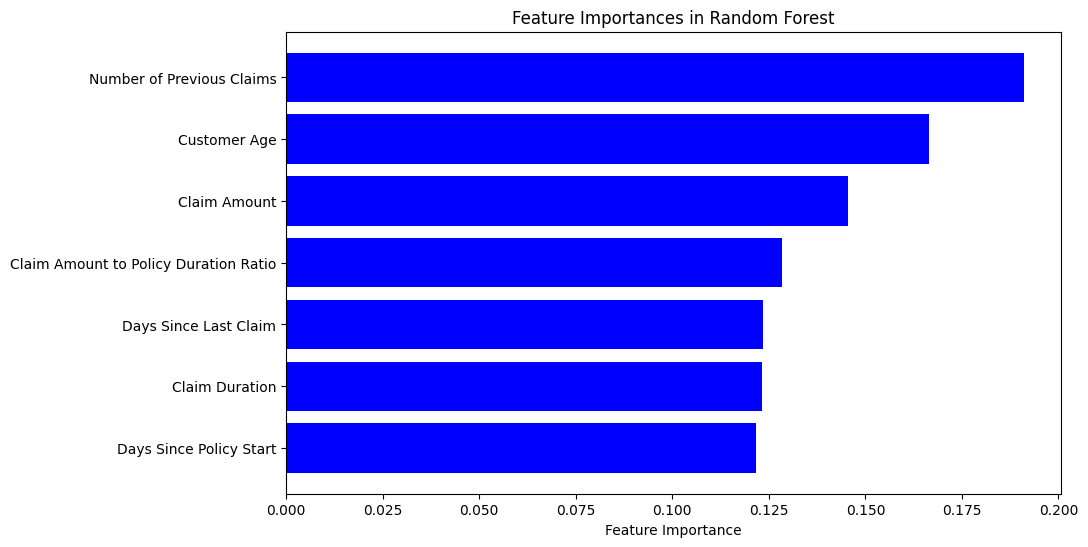

In [21]:
# Get feature importances from the Random Forest model
importances = rf_clf.feature_importances_
feature_names = features

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='b')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in Random Forest')
plt.gca().invert_yaxis()
plt.show()


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Load the data
data = pd.read_csv('synthetic_car_insurance_claims.csv')

# Convert date columns to datetime
data['Claim Date'] = pd.to_datetime(data['Claim Date'])
data['Policy Start Date'] = pd.to_datetime(data['Policy Start Date'])
data['Policy End Date'] = pd.to_datetime(data['Policy End Date'])

# Create new features
data['Policy Duration'] = (data['Policy End Date'] - data['Policy Start Date']).dt.days
data['Days Since Policy Start'] = (data['Claim Date'] - data['Policy Start Date']).dt.days
data['Claim Amount to Policy Duration Ratio'] = data['Claim Amount'] / data['Policy Duration']

# Adjust the feature list based on the new features
features = [
    'Claim Amount', 
    'Customer Age', 
    'Number of Previous Claims', 
    'Claim Duration', 
    'Days Since Last Claim', 
    'Days Since Policy Start', 
    'Claim Amount to Policy Duration Ratio'
]

# Feature engineering verification
X = data[features]
y = data['Is Fraud']

# Check for missing values and handle them
imputer = KNNImputer(n_neighbors=5)  # Using KNN imputer instead of mean imputer
X = imputer.fit_transform(X)

# Data normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Convert y_resampled to numpy array to avoid indexing issues
y_resampled = np.array(y_resampled)

# Define helper functions for SOM

def get_neuron_labels(som, X_train, y_train):
    labels_map = {}
    for i, x in enumerate(X_train):
        w = som.winner(x)
        if w not in labels_map:
            labels_map[w] = []
        labels_map[w].append(y_train[i])
    for k in labels_map:
        labels_map[k] = np.argmax(np.bincount(labels_map[k]))
    return labels_map

def predict(som, labels_map, X_test):
    y_pred = []
    default_label = 0  # or you can choose 1, depending on your preference
    for x in X_test:
        w = som.winner(x)
        if w in labels_map:
            y_pred.append(labels_map[w])
        else:
            y_pred.append(default_label)  # Assign a default label if the neuron was not labeled
    return np.array(y_pred)

# Define the number of folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
accuracies = []

# Perform cross-validation with different parameters
param_grid = {
    'sigma': [0.5, 1.0, 1.5],
    'learning_rate': [0.1, 0.3, 0.5],
    'iterations': [1000, 2000, 3000],
    'grid_size': [20, 25, 30]
}

best_accuracy = 0
best_params = {}

for sigma in param_grid['sigma']:
    for learning_rate in param_grid['learning_rate']:
        for iterations in param_grid['iterations']:
            for grid_size in param_grid['grid_size']:
                accuracies = []
                for train_index, test_index in kf.split(X_resampled):
                    X_train_cv, X_test_cv = X_resampled[train_index], X_resampled[test_index]
                    y_train_cv, y_test_cv = y_resampled[train_index], y_resampled[test_index]
                    
                    # Train the SOM
                    som = MiniSom(grid_size, grid_size, X_train_cv.shape[1], sigma=sigma, learning_rate=learning_rate, random_seed=42)
                    som.random_weights_init(X_train_cv)
                    som.train_random(X_train_cv, iterations)
                    
                    # Map each neuron to the majority class of the training samples mapped to it
                    labels_map = get_neuron_labels(som, X_train_cv, y_train_cv)
                    
                    # Predict the labels for the test set
                    y_pred_cv = predict(som, labels_map, X_test_cv)
                    
                    # Compute the accuracy
                    acc = accuracy_score(y_test_cv, y_pred_cv)
                    accuracies.append(acc)
                
                avg_accuracy = np.mean(accuracies)
                if avg_accuracy > best_accuracy:
                    best_accuracy = avg_accuracy
                    best_params = {
                        'sigma': sigma,
                        'learning_rate': learning_rate,
                        'iterations': iterations,
                        'grid_size': grid_size
                    }

print("Best Cross-Validation Accuracy: {:.2f}%".format(best_accuracy * 100))
print("Best Parameters:", best_params)

# Final model training and evaluation with best parameters
# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Train the SOM
som = MiniSom(best_params['grid_size'], best_params['grid_size'], X_train.shape[1], sigma=best_params['sigma'], learning_rate=best_params['learning_rate'], random_seed=42)
som.random_weights_init(X_train)
som.train_random(X_train, best_params['iterations'])

# Map each neuron to the majority class of the training samples mapped to it
labels_map = get_neuron_labels(som, X_train, y_train)

# Predict the labels for the test set
y_pred_som = predict(som, labels_map, X_test)

# Compute the confusion matrix for SOM
cm_som = confusion_matrix(y_test, y_pred_som)
print("Confusion Matrix (SOM):")
print(cm_som)

# Compute classification report for SOM
report_som = classification_report(y_test, y_pred_som, target_names=['Non-Fraud', 'Fraud'])
print("Classification Report (SOM):")
print(report_som)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Compute the confusion matrix for Random Forest model
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(cm_rf)

# Compute classification report for Random Forest model
report_rf = classification_report(y_test, y_pred_rf, target_names=['Non-Fraud', 'Fraud'])
print("Classification Report (Random Forest):")
print(report_rf)

# Ensemble method for final prediction using Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('som', rf),
    ('rf', rf),
], voting='hard')

voting_clf.fit(X_train, y_train)
y_pred_vc = voting_clf.predict(X_test)

# Compute confusion matrix for ensemble method
cm_vc = confusion_matrix(y_test, y_pred_vc)
print("Confusion Matrix (Ensemble):")
print(cm_vc)

# Compute classification report for ensemble method
report_vc = classification_report(y_test, y_pred_vc, target_names=['Non-Fraud', 'Fraud'])
print("Classification Report (Ensemble):")
print(report_vc)


Best Cross-Validation Accuracy: 80.75%
Best Parameters: {'sigma': 0.5, 'learning_rate': 0.5, 'iterations': 3000, 'grid_size': 30}
Confusion Matrix (SOM):
[[1033  392]
 [ 193 1234]]
Classification Report (SOM):
              precision    recall  f1-score   support

   Non-Fraud       0.84      0.72      0.78      1425
       Fraud       0.76      0.86      0.81      1427

    accuracy                           0.79      2852
   macro avg       0.80      0.79      0.79      2852
weighted avg       0.80      0.79      0.79      2852

Confusion Matrix (Random Forest):
[[1355   70]
 [  47 1380]]
Classification Report (Random Forest):
              precision    recall  f1-score   support

   Non-Fraud       0.97      0.95      0.96      1425
       Fraud       0.95      0.97      0.96      1427

    accuracy                           0.96      2852
   macro avg       0.96      0.96      0.96      2852
weighted avg       0.96      0.96      0.96      2852

Confusion Matrix (Ensemble):
[[1355 

In [8]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import os

# Load the original dataset
data = pd.read_csv('synthetic_car_insurance_claims.csv')

# Convert date columns to datetime
data['Claim Date'] = pd.to_datetime(data['Claim Date'])
data['Policy Start Date'] = pd.to_datetime(data['Policy Start Date'])
data['Policy End Date'] = pd.to_datetime(data['Policy End Date'])

# Create new features
data['Policy Duration'] = np.abs((data['Policy End Date'] - data['Policy Start Date']).dt.days)
data['Days Since Policy Start'] = np.abs((data['Claim Date'] - data['Policy Start Date']).dt.days)
data['Claim Amount to Policy Duration Ratio'] = np.abs(data['Claim Amount'] / data['Policy Duration'])

# Add a new feature 'Policy Members' (simulating number of people in the policy)
data['Policy Members'] = np.random.randint(1, 6, size=len(data))

# Adjust the feature list based on the new features
features = [
    'Customer Age', 
    'Number of Previous Claims', 
    'Claim Duration', 
    'Days Since Last Claim', 
    'Days Since Policy Start', 
    'Claim Amount to Policy Duration Ratio',
    'Policy Members'
]

# Prepare the feature matrix X and target vector y
X = data[features]
y = data['Is Fraud']

# Check for missing values and handle them
imputer = KNNImputer(n_neighbors=5)
X = imputer.fit_transform(X)

# Data normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Ensemble method for final prediction using Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', rf),
], voting='hard')

voting_clf.fit(X_train, y_train)

# Predict on the entire dataset using the trained model
y_pred = voting_clf.predict(X_scaled)

# Add the predictions to the original dataset
data['Fraud Status'] = np.where(y_pred == 1, 'Fraud', '')

# Select only the columns you want to keep, including the new 'Policy Members'
columns_to_keep = ['Claim Date', 'Customer ID', 'Customer Age', 'Customer Gender', 'Policy ID', 'Policy Members', 'Fraud Status']

# Filter the dataset to keep only the required columns
data_filtered = data[columns_to_keep]

# Sort the dataset by Claim Date
data_filtered_sorted = data_filtered.sort_values(by='Claim Date')

# Save the filtered and sorted dataset to an Excel file
excel_filename = 'AS_synthetic_car_insurance_claims_sorted.xlsx'
data_filtered_sorted.to_excel(excel_filename, index=False)

# Display the path where the file is saved
file_path = os.path.abspath(excel_filename)
print(f'The dataset has been saved to {file_path}')

# Display the first few rows to check
print(data_filtered_sorted.head())


The dataset has been saved to C:\Users\smart\AS_synthetic_car_insurance_claims_sorted.xlsx
     Claim Date  Customer ID  Customer Age Customer Gender  Policy ID  \
2414 2010-01-01          483            43            Male        483   
2253 2010-01-02          817            43            Male        817   
3592 2010-01-02          115            39            Male        115   
3822 2010-01-03          183            67          Female        183   
1017 2010-01-04          514            53            Male        514   

      Policy Members Fraud Status  
2414               1               
2253               3               
3592               5               
3822               5               
1017               1               
